#**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

#**Curso: TC4034 - Análisis de grandes volúmenes de datos**

#Tecnológico de Monterrey

#**Semana 6**

#Avance de proyecto 2: Sistema de Recomendación

#**Equipo 20**

#   Zmaltzin Paola Godínez Juárez - A01794538

#   Julio César Mestas Delgado    - A01794827

# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [1]:
!pip install fuzzywuzzy
!pip install sentence_transformers

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [3]:
# Importando los datos
netflix = pd.read_csv("/content/data/netflix_titles.csv")
netflix = netflix.dropna()    # Eliminando valores nulos
netflix.drop(                    # Eliminando columnas que no se utilizarán
    columns=[
        "director",
        "cast",
        "country",
        "date_added",
        "rating",
        "duration",
    ],
    inplace=True,
)
# Imprimiendo los primeros 10 renglones del dataframe
netflix.head(10)

,show_id,type,title,year,listed_in,description
7,s8,Movie,Sankofa,1993,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,2021,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,2021,"Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,2021,"Dramas, International Movies",After most of her family is murdered in a terr...
24,s25,Movie,Jeans,1998,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
27,s28,Movie,Grown Ups,2010,Comedies,Mourning the loss of their beloved junior high...
28,s29,Movie,Dark Skies,2013,"Horror Movies, Sci-Fi & Fantasy",A family’s idyllic suburban life shatters when...
29,s30,Movie,Paranoia,2013,Thrillers,"Blackmailed by his company's CEO, a low-level ..."
38,s39,Movie,Birth of the Dragon,2017,"Action & Adventure, Dramas",A young Bruce Lee angers kung fu traditionalis...
41,s42,Movie,Jaws,1975,"Action & Adventure, Classic Movies, Dramas",When an insatiable great white shark terrorize...


Podemos ver que el dataset cuenta con el id del show|pelicula, el titulo y los generos asociados a dicha pelicula, además de identificadordel usuario, el rating y el año

## Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los generos de las peliculas estan expresados en un string separados por un coma "," . Debemos manipular este string en una lista que nos facilitara el analisis de los datos.
2. Se eliminan los espacios en blanco antes y despues de cada string en la lista de generos


#### Transformando los Generos de un String a una lista


Utilizaremos la funcion "split" para separar los generos de la columna con el mismo nombre.

In [4]:
netflix['listed_in'] = netflix['listed_in'].apply(lambda x: x.split(","))
netflix.head()

,show_id,type,title,year,listed_in,description
7,s8,Movie,Sankofa,1993,"[Dramas, Independent Movies, International M...","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,2021,"[British TV Shows, Reality TV]",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,2021,"[Comedies, Dramas]",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,2021,"[Dramas, International Movies]",After most of her family is murdered in a terr...
24,s25,Movie,Jeans,1998,"[Comedies, International Movies, Romantic Mo...",When the father of the man she loves insists t...


In [5]:
def clean_text(text_list):
    cleaned_list = []
    for text in text_list:
        cleaned_text = text.strip()
        cleaned_list.append(cleaned_text)
    return cleaned_list

# Apply the clean_text function to the listed_in column
netflix["listed_in"] = netflix["listed_in"].apply(clean_text)
netflix.head()

,show_id,type,title,year,listed_in,description
7,s8,Movie,Sankofa,1993,"[Dramas, Independent Movies, International Mov...","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,2021,"[British TV Shows, Reality TV]",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,2021,"[Comedies, Dramas]",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,2021,"[Dramas, International Movies]",After most of her family is murdered in a terr...
24,s25,Movie,Jeans,1998,"[Comedies, International Movies, Romantic Movies]",When the father of the man she loves insists t...


#### Calculemos cuantos generos de peliculas y shows contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [6]:
from collections import Counter

contador_generos = Counter(g for genres in netflix['listed_in'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

Existen 42 tipos de generos.


Counter({'Dramas': 2293,
         'Independent Movies': 740,
         'International Movies': 2369,
         'British TV Shows': 21,
         'Reality TV': 3,
         'Comedies': 1553,
         'Romantic Movies': 579,
         'Horror Movies': 336,
         'Sci-Fi & Fantasy': 236,
         'Thrillers': 547,
         'Action & Adventure': 806,
         'Classic Movies': 108,
         'Anime Features': 61,
         'Children & Family Movies': 503,
         'Documentaries': 391,
         'Music & Musicals': 292,
         'Cult Movies': 69,
         'Faith & Spirituality': 58,
         'LGBTQ Movies': 80,
         'Crime TV Shows': 38,
         'International TV Shows': 87,
         'TV Dramas': 52,
         'Romantic TV Shows': 21,
         'Spanish-Language TV Shows': 10,
         'Stand-Up Comedy': 294,
         'TV Shows': 5,
         'Movies': 20,
         'TV Comedies': 30,
         'Sports Movies': 156,
         'TV Action & Adventure': 13,
         'TV Sci-Fi & Fantasy': 4,
     

Existen 42 diferentes etiquetas para los generos.


#### Cuales son los generos de peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [7]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('International Movies', 2369), ('Dramas', 2293), ('Comedies', 1553), ('Action & Adventure', 806), ('Independent Movies', 740), ('Romantic Movies', 579), ('Thrillers', 547), ('Children & Family Movies', 503), ('Documentaries', 391), ('Horror Movies', 336)]


En el Top 10 de generos encontramos: `International Movies`, `Dramas`, `Comedies`, `Accion & Adventure`,`Independent Movies`, `Romantic Movies`, `Thrillers`, , `Children & Family Movies`, `Documentaries` y `Horror Movies`.

Utilizemos barplot para visualizar esta informacion.

<ipython-input-8-1f785b21dbb8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='count', data=genres_counts_df, palette='crest')


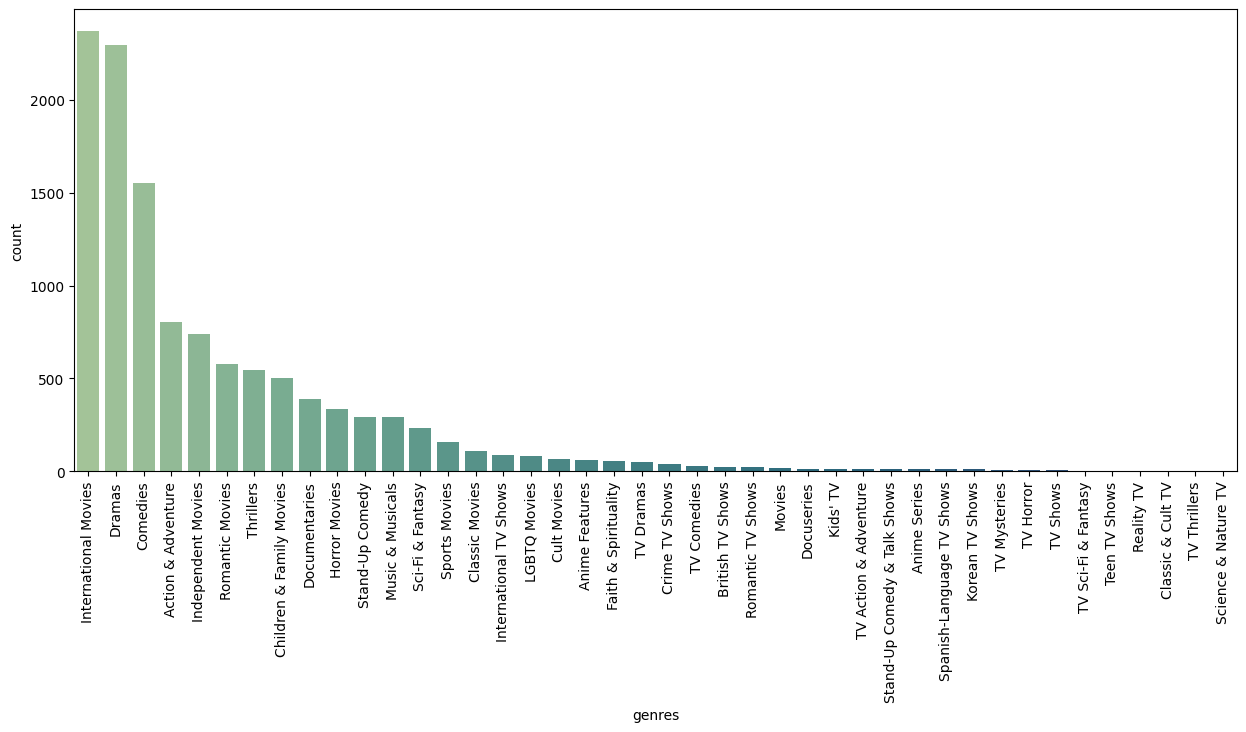

In [8]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(15,6))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='crest')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `International Movies`, `Movies` y `Comedies` son los generos mas populares mientras que los `Classic & Cult TV`, `TV Thrillers`, and `Science & Nature TV` son los menos populares.

#### Cuantos año distintos estan contenidos en nuestro dataset?


In [9]:
unique_years = netflix['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 72


Con este calculo rapido, nos percatamos que contamos con mas de 72 años en nuestro dataset. Lo que podemos hacer ahora es dividir nuestros datos en decadas para tener una idea en general de cuando fueron lanzadas las peliculas de nuestro dataset.

#### Cual fue la decada mas popular para estrenar una pelicula/show?

Analizemos el dataset para conocer el numero de peliculas contenidas.

In [10]:
print(f"Numero total de peliculas/shows en el dataset: {netflix['show_id'].nunique()}")

Numero total de peliculas/shows en el dataset: 5332


Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [11]:
netflix = netflix[~netflix['year'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el año:: {netflix['show_id'].nunique()}")


Total de peliculas despues de eliminar aquellas con null en el año:: 5332


Esto nos dice que todas las peliculas/shows contabancon con el año de lanzamiento:

Existen dos formas de calcular la decada de un año:

1. convertir el año a string y remplazar el ultimo digito con un 0

2. redondear el año al decimo (10) proximo

In [12]:
x = 1995

def calcular_decada(year):
    year = str(year)
    decade_prefix = year[0:3] # obtener los primeros 3 digitos de un año
    decade = f'{decade_prefix}0' # añadir un 0 al final
    return int(decade)

calcular_decada(x)

1990

In [13]:
def redondear(year):
    return year - (year%10)

redondear(x)

1990

Ambas funciones `calcular_decada()` y `redondear()` cumplen con el objetivo de identificar la decada de un año.

Podemos aplicar cualquiera de ellas a todos los años de nuestro dataset `Netflix_df` y al mismo tiempo crearemos una columna llamada `decade`.


In [14]:
netflix['decade'] = netflix['year'].apply(redondear)

## Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las peliculas y las columnas las caracteristicas (generos y decadas)


Primero, debemos manipular la columna de `generos` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [15]:
genres = list(contador_generos.keys())

for g in genres:
    netflix[g] = netflix['listed_in'].transform(lambda x: int(g in x))

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [16]:
netflix[genres].head()

,Dramas,Independent Movies,International Movies,British TV Shows,Reality TV,Comedies,Romantic Movies,Horror Movies,Sci-Fi & Fantasy,Thrillers,...,Docuseries,Anime Series,TV Horror,Teen TV Shows,Korean TV Shows,Stand-Up Comedy & Talk Shows,Kids' TV,Classic & Cult TV,TV Thrillers,Science & Nature TV
7,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los generos se representan como columnas con propiedades binarias. Ahora debemos asignar las distintas decadas a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [17]:
movie_decades = pd.get_dummies(netflix['decade'])
movie_decades.head()

,1940,1950,1960,1970,1980,1990,2000,2010,2020
7,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,True
9,False,False,False,False,False,False,False,False,True
12,False,False,False,False,False,False,False,False,True
24,False,False,False,False,False,True,False,False,False


Lo siguiente es crear un nuevo dataframe con las propiedades de de decada y genero de las peliculas en `movie_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [18]:
movie_features = pd.concat([netflix[genres], movie_decades], axis=1)
movie_features.head()

,Dramas,Independent Movies,International Movies,British TV Shows,Reality TV,Comedies,Romantic Movies,Horror Movies,Sci-Fi & Fantasy,Thrillers,...,Science & Nature TV,1940,1950,1960,1970,1980,1990,2000,2010,2020
7,1,1,1,0,0,0,0,0,0,0,...,0,False,False,False,False,False,True,False,False,False
8,0,0,0,1,1,0,0,0,0,0,...,0,False,False,False,False,False,False,False,False,True
9,1,0,0,0,0,1,0,0,0,0,...,0,False,False,False,False,False,False,False,False,True
12,1,0,1,0,0,0,0,0,0,0,...,0,False,False,False,False,False,False,False,False,True
24,0,0,1,0,0,1,1,0,0,0,...,0,False,False,False,False,False,True,False,False,False


El dataframe `movie_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

## Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (5332, 5332)


Esto nos indica que al evaluar la similitud de coseno del dataframe `movie_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre peliculas similares

Si por ejemplo queremos encontrar peliculas que sean similares a `Jumanji` en nuestro sistema de recomendacion, necesitamos saber el titulo de una pelicula en nuestro dataset.

Afortunadamente la pelicula esta listada como `'Jumanji (1995)'`. Sin embargo, si deletreamos mal el nombre u olvidamos incluir el año de su lanzamiento, el sistema no sabra que pelicula es a la que nos estamos refiriendo.

Con el fin de que nuestro sistema sea mas amigable para el usuario, utilizaremos un paquete llamado `fuzzywuzzy` que nos ayudara a encontrar el titulo de la pelicula mas parecido a partir del string que le pasemos.

Con base en esto, crearemos una funcion que se llame `encuentra_pelicula()` que implementa el algoritmo de matching de strings de `fuzzywuzzy` para hallar el titulo mas parecido a partir de un string ingresado por el usuario.

In [20]:
from fuzzywuzzy import process

def encuentra_pelicula(title):
    all_titles = netflix['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `Paranoia`

In [21]:
title = encuentra_pelicula('paranoa')
print(f"El titulo correcto de la pelicula es: {title}")

El titulo correcto de la pelicula es: Paranoia


Ahora que ya no nos preocupamos por escribir mal el titulo de una pelicula, lo que nos interesa es encontrar recomendaciones relevantes a partir de la pelicula que deseamos.

Deseamos encontrar el indice de la pelicula en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de indices de peliculas/series que encuentre el titulo de una pelicula y le asigne el indice que representa en nuestra matriz.

Crearemos un diccionario llamado `movie_idx` donde las llaves son los titulos de las peliculas y los valores son los indices de las peliculas.

In [22]:
movie_idx = dict(zip(netflix['title'], list(netflix.index)))
idx = movie_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula Paranoia en la matriz movie_idx es: 29


Al usar el diccionario `movie_idx`, sabemos que Jumanji se representa por el indice 1 en nuestra matriz.

Ahora tratemos de encontrar las 10 peliculas mas similares a Paranoia.

In [23]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso Paranoia). Podemos encontrar el titulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de titulo del dataframe `netflix`.

In [24]:
print(f"Por que miraste la pelicula {title}, te pueden interesar las siguientes {numero_recomendaciones} peliculas:")
netflix['title'].iloc[similar_movies]

Por que miraste la pelicula Paranoia, te pueden interesar las siguientes 10 peliculas:


2873        Ala Vaikunthapurramuloo
9                      The Starling
247                      Sweet Girl
295                The Paper Tigers
618     America: The Motion Picture
1088                  Thunder Force
1584                            Ava
1921                    The Outpost
2393                    Da 5 Bloods
2709                Coffee & Kareem
Name: title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas.

In [25]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_pelicula(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las peliculas recomendadas con base en la pelicula {title} son:")
    print(netflix['title'].iloc[similar_movies])

In [26]:
obtener_recomendaciones_basadas_contenido('The conjuring', 5)

Las peliculas recomendadas con base en la pelicula The Conjuring son:
436     The Tambour of Retribution
756                    Small Chops
913                  Time to Dance
994          This Lady Called Life
1031                 Into the Beat
Name: title, dtype: object


## Step 6: Algoritmo de recomendacion avanzado elegido: Sistema de recomendación usando Sentence Transformer

Este es un modelo de transformadores de oraciones. Este marco se puede utilizar para calcular incrustaciones (embeddings) y estas incrustaciones se pueden comparar, por ejemplo, utilizando la similitud de coseno para encontrar oraciones con significados similares. Los modelos se basan en redes de transformadores y logran un excelente rendimiento en una variedad de tareas. El texto se incrusta en el espacio vectorial de tal manera que el texto similar está cerca y se puede encontrar rápidamente mediante la similitud del coseno.

In [27]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-distilroberta-base-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Posteriormente se buscan incrustaciones (embeddings) para todas las descripciones de programas en el conjunto de datos.

In [28]:
descriptions = netflix["description"].tolist()
# print(descriptions)
des_embeddings = []
for i, des in enumerate(descriptions):
    des_embeddings.append(model.encode(des))

Para una consulta de un show_id especifico, se buscan los diez programas con la mayor similitud de coseno como en el sistema de recomendación anterior.

In [29]:
import torch
from sentence_transformers import util


def recommend(query):
    query_embedded = model.encode(query)
    cosine_scores = util.pytorch_cos_sim(query_embedded, des_embeddings)
    top10_matches = torch.argsort(cosine_scores, dim=-1, descending=True).tolist()[0][
        1:11
    ]
    return top10_matches

Recomendador de películas usando transformadores de oraciones

In [30]:
title = "The Conjuring"
query_show_des = netflix.loc[netflix["title"] == title]["description"].to_list()[0]

recommended_results = recommend(query_show_des)
recommended_results = [x + 1 for x in recommended_results]

for i in range(len(recommended_results)):
    print(
        netflix["title"].loc[
            netflix["show_id"] == str("s" + str(recommended_results[i]))
        ]
    )

Series([], Name: title, dtype: object)
Series([], Name: title, dtype: object)
821    The Wedding Guest
Name: title, dtype: object
Series([], Name: title, dtype: object)
4697    The Motive
Name: title, dtype: object
Series([], Name: title, dtype: object)
2930    Love for Sale 2
Name: title, dtype: object
3951    Jagat
Name: title, dtype: object
Series([], Name: title, dtype: object)
4401    All's Well, End's Well (2009)
Name: title, dtype: object


/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  b = torch.tensor(b)


## Comentarios

Bajo este esquema el sistema de recomendación basado en transformadores muestra resultados más robustos, ya que utiliza una mayor cantidad de información como la completa descripción de la película que la implementación por medio de matrices de las propiedades de decada y genero. Ambas implementaciones utilizan como métrica de similitud del coseno.